In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from scipy.linalg import hankel
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import os
import platform
# import structures
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
# Torch
import torch
import torch.nn as nn
import torch.distributions as D
import torch.functional as F

### Read data

In [2]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [3]:
# Load data
neu_path = basepath+"/session_struct/lip/neurons/2023-11-30_11-16-24_Riesling_lip_e1_r1_good1_neu.h5"#2023-11-30_11-16-24_Riesling_lip_e1_r1_good1   2023-12-06_11-17-19_Riesling_lip_e1_r1_good4
neu_data = NeuronData.from_python_hdf5(neu_path)

### Preproces data
* select trials 
* define stimulus
* define basis
* convole stimulus with its corresponding base -> desing matrix
* stack spikes and desing matrices

In [4]:
# parameters
time_before=0
select_block=1
# start=-200
# end=1200
# idx_start = time_before + start 
# idx_end = time_before+end

In [5]:
# Select trials aligned to start_trial
code=1
sp_sample_on,mask = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= select_block,
    select_pos= code,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
)

In [6]:
import glm_functions

In [7]:
# Number of basis for each stimulus
fix_cue_dim=4
fixation_dim=5
sample_dim=15
delay_dim=15
test_dim=10
match_dim=4
bar_dim=4
hist_cos_dim = 10
hist_box_dim = 10
hist_dim = hist_cos_dim+hist_box_dim
# Compute basis
cos_basis=glm_functions.make_non_linear_raised_cos(nBases=hist_cos_dim, binSize=1, endPoints=np.array([10,150]), nlOffset=1)
single_bin_boxcars = np.zeros((cos_basis.shape[0],hist_box_dim))
single_bin_boxcars[range(hist_box_dim),range(hist_box_dim)]=1
hist_basis = np.concatenate((single_bin_boxcars,cos_basis),axis=1)
fix_cue_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fix_cue_dim,duration=500)
fixation_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fixation_dim,duration=1200)
sample_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=sample_dim,duration=400)
delay_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=delay_dim,duration=400)
test_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=test_dim,duration=400)
match_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=match_dim,duration=400)
bar_release_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=bar_dim,duration=80)
basis={'fix_cue':fix_cue_basis,'fixation':fixation_basis,'hist':hist_basis,
       's_on_off':[np.nan],
       's_o1':sample_basis,'s_o5':sample_basis,
       's_c1':sample_basis,'s_c5':sample_basis,'s_n0':sample_basis,
       'd_o1':delay_basis,'d_o5':delay_basis,'d_c1':delay_basis,'d_c5':delay_basis,'d_n0':delay_basis,'d_on_off':[np.nan]}
for i in range(1,9):
    basis['test_color'+str(i)] = test_basis
    basis['test_orient'+str(i)] = test_basis
for i in range(1,5):
    basis['test_on_off'+str(i)] = [np.nan]
basis['match'] = match_basis
basis['bar_release'] = bar_release_basis

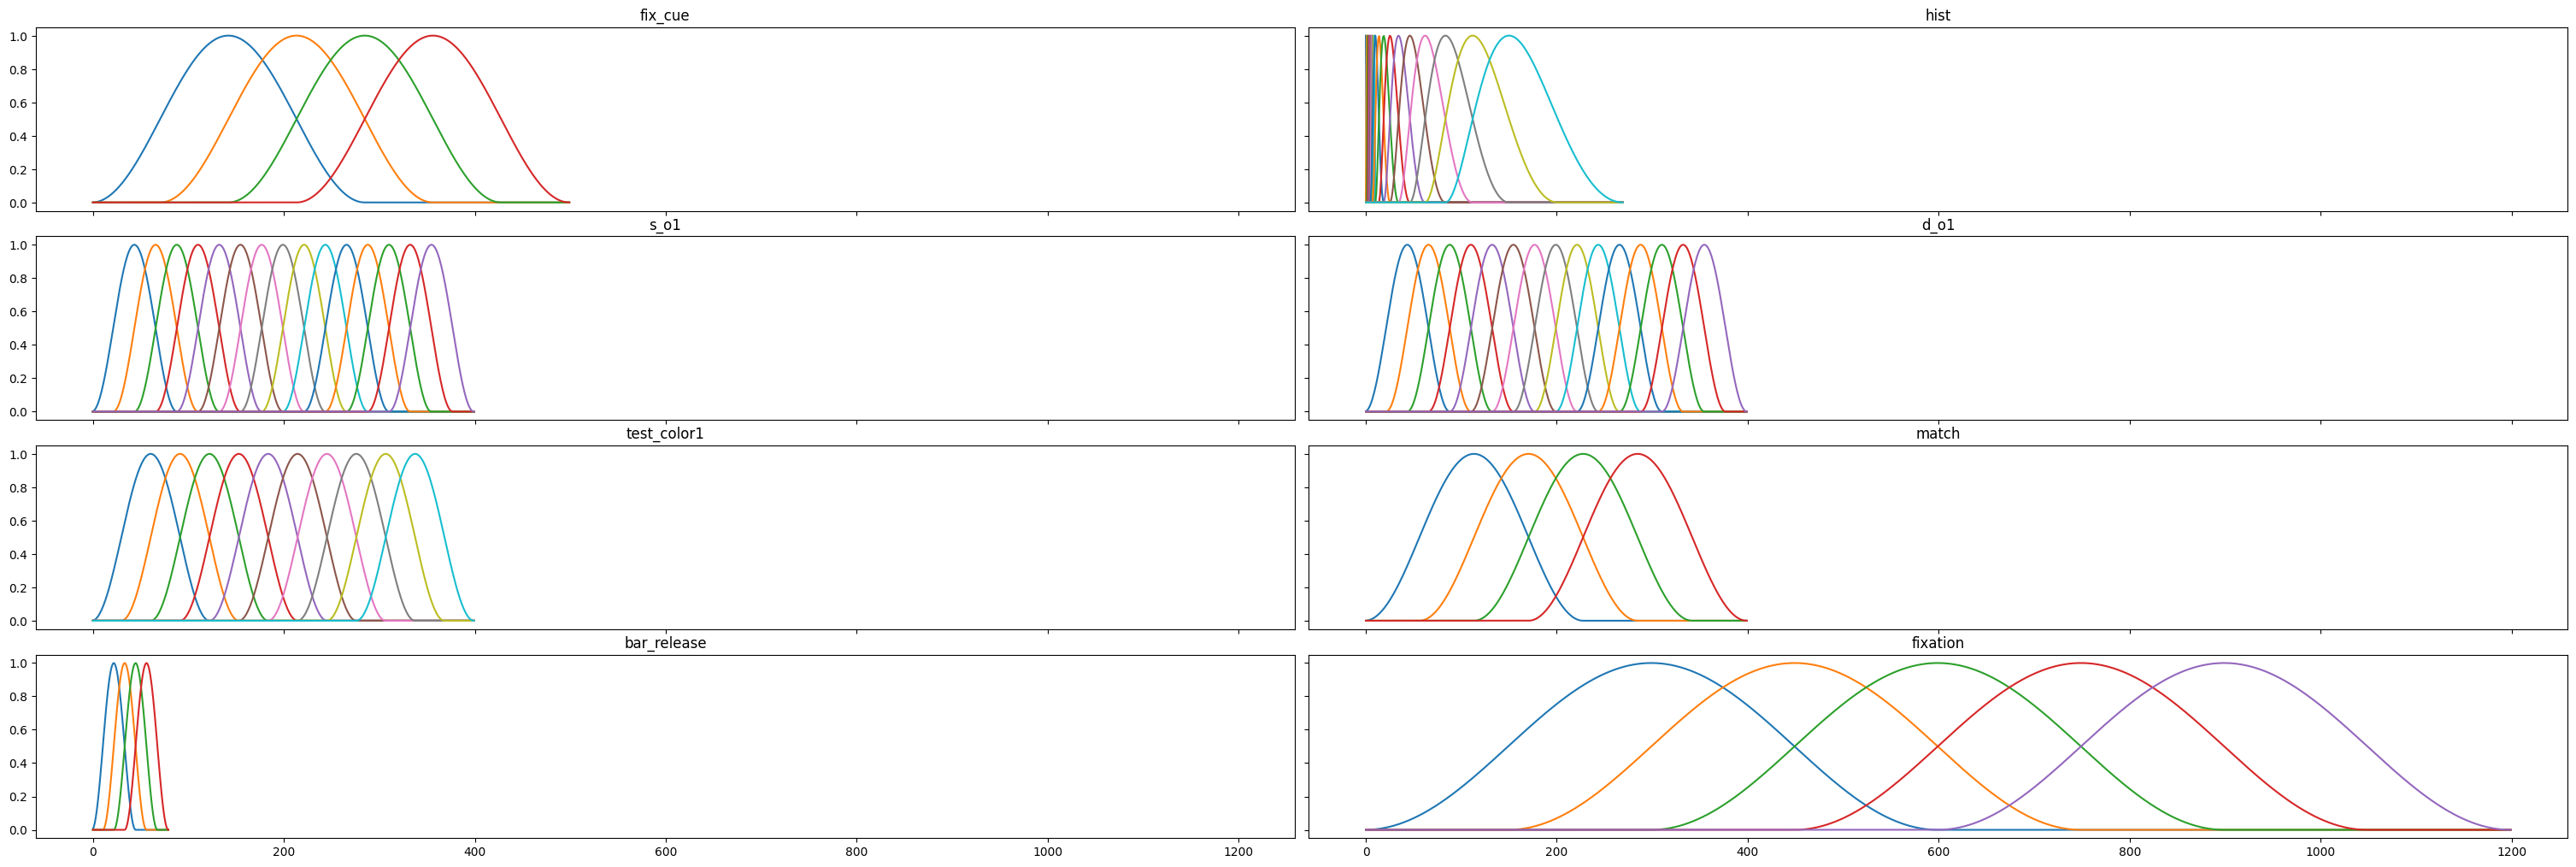

In [8]:
# print filters
basis_keys = ['fix_cue', 'hist', 's_o1', 'd_o1', 'test_color1', 'match', 'bar_release','fixation']
cols = 2
rows = len(basis_keys)//cols
rows =rows +1 if len(basis_keys)%cols>0 else rows
f,ax=plt.subplots(rows,cols,figsize=(30,10),sharey=True,sharex=True)
for iax,var in zip(np.concatenate(ax),basis_keys):
    iax.plot(basis[var])
    iax.set_title(var)
f.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [9]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [10]:
basis['fixation'].shape

(1200, 5)

In [11]:
# iterate over trials
def get_dm(i_tr):

    e_time = neu_data.code_samples[mask][i_tr]-neu_data.code_samples[mask][i_tr][4]+time_before
    e_code = neu_data.code_numbers[mask][i_tr]
    test_stimuli = neu_data.test_stimuli[mask][i_tr]
    # n_test=np.sum(~np.isnan(test_stimuli))
    reward = task_constants.EVENTS_B1[last_event]
    idx_last = np.where(e_code==reward)[0]

    len_tr=int(e_time[idx_last][0]+10)
    sample_id = neu_data.sample_id[mask][i_tr]
    stim = glm_functions.def_stim(events,len_tr,e_time,e_code,sample_id,sp_sample_on[i_tr,:len_tr],test_stimuli)
    all_dm = {}
    indices = {}
    design_mat=np.zeros((len_tr,1))
    shape = 0
    for key in events:
        base=basis[key]
        if np.any(np.isnan(base)):
            all_dm[key]=stim[key][:,np.newaxis]
        else:
            sb_conv = signal.convolve2d(stim[key][:,np.newaxis],base)
            all_dm[key]=sb_conv[:len_tr]
        indices[key]=[shape,shape+all_dm[key].shape[1]]
        shape = shape+all_dm[key].shape[1]
        design_mat = np.concatenate((design_mat,all_dm[key]), axis=1)

    return {"design_mat":design_mat[:,1:],"all_dm":all_dm,"stim":stim,"len_tr":len_tr,"s_on":e_time[4],"fix_on":e_time[2],"delay_on":e_time[5],"test1_on":e_time[6],"indices":indices,"sp":sp_sample_on[i_tr,:len_tr]}


In [12]:
events = [
    # "fix_cue",
    # "fixation",
    "hist",
    "s_o1",
    "s_o5",
    "s_c1",
    "s_c5",
    "s_n0",
    "s_on_off",
    "d_o1",
    "d_o5",
    "d_c1",
    "d_c5",
    "d_n0",
    "d_on_off",
    # "test_orient1",
    # "test_orient2",
    # "test_orient3",
    # "test_orient4",
    # "test_orient5",
    # "test_orient6",
    # "test_orient7",
    # "test_orient8",
    # "test_color1",
    # "test_color2",
    # "test_color3",
    # "test_color4",
    # "test_color5",
    # "test_color6",
    # "test_color7",
    # "test_color8",
    # "match",
    # "bar_release",
]
last_event = "test_on_1"#"reward"

In [13]:
sample_id=neu_data.sample_id[mask]
sn0= np.where(sample_id== 0)[0][:10]
s15= np.where(sample_id== 15)[0][:10]
s11= np.where(sample_id== 11)[0][:10]
s55= np.where(sample_id== 55)[0][:10]
s51= np.where(sample_id== 51)[0][:10]
idxs_train =np.concatenate((sn0,s15,s11,s55,s51))
rng = np.random.default_rng(seed=2024)
rng.shuffle(idxs_train)

sample_id=neu_data.sample_id[mask]
sn0= np.where(sample_id== 0)[0][15:20]
s15= np.where(sample_id== 15)[0][15:20]
s11= np.where(sample_id== 11)[0][15:20]
s55= np.where(sample_id== 55)[0][15:20]
s51= np.where(sample_id== 51)[0][15:20]
idxs_test =np.concatenate((sn0,s15,s11,s55,s51))
rng = np.random.default_rng(seed=2024)
rng.shuffle(idxs_test)
idxs_test
idxs = np.concatenate((idxs_train,idxs_test))

In [14]:
n_tr,_ = sp_sample_on.shape
data    =   Parallel(n_jobs = -1)(delayed(get_dm)(i_tr) for i_tr in tqdm(idxs))

100%|██████████| 75/75 [00:34<00:00,  2.17it/s]


In [15]:
design_mat = []
all_dm =[]
all_len_tr = []
all_s_on = []
all_fix_on=[]
all_stim=[]
all_sp = []
all_d_on=[]
all_test1_on=[]
for asc in data:
    design_mat.append(asc["design_mat"])
    all_dm.append(asc["all_dm"])
    all_len_tr.append(asc["len_tr"])
    all_s_on.append(asc["s_on"])
    all_fix_on.append(asc["fix_on"])
    all_d_on.append(asc["delay_on"])
    all_stim.append(asc["stim"])
    all_sp.append(asc["sp"])
    all_test1_on.append(asc["test1_on"])
indices= data[0]["indices"]

In [16]:
all_stim[0].keys()

dict_keys(['hist', 's_on_off', 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 'not_engage', 'd_on_off', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0'])

In [17]:
i_trs=0
neu_data.sample_id[mask][idxs_train][i_trs]

55.0

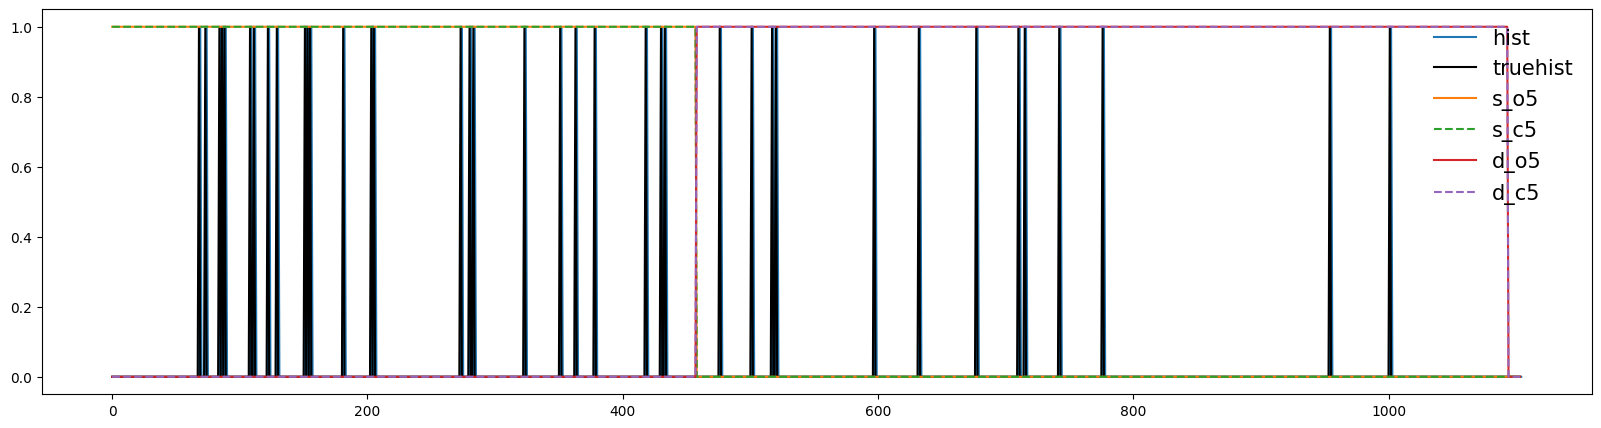

In [18]:
f,ax=plt.subplots(figsize=(20,5))
#ax.plot(all_stim[0]['fixation'],label='fixation')
ax.plot(all_stim[0]['hist'],label='hist')
ax.plot(all_sp[0],'k',label='truehist')
#ax.plot(all_stim[0]['fix_cue'],label='fix_cue')
ax.plot(all_stim[0]['s_o5'],label='s_o5')
ax.plot(all_stim[0]['s_c5'],label='s_c5',linestyle='--')
ax.plot(all_stim[0]['d_o5'],label='d_o5')
ax.plot(all_stim[0]['d_c5'],label='d_c5',linestyle='--')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [19]:
n_train_tr = len(idxs_train)#int(100*0.490)
n_train_tr

50

In [20]:
# train
sp_train=np.concatenate(all_sp[:n_train_tr])
print("Length of all trials concatenated: %s"%sp_train.shape)
dm_train=np.concatenate(design_mat[:n_train_tr])
print("Shape of dm: (%s, %s)"%dm_train.shape)
len_tr_train=np.array(all_len_tr)[:n_train_tr]
print("Number of trials %s"%len_tr_train.shape)
s_on_train=np.array(all_s_on)[:n_train_tr]
fix_on_train=np.array(all_fix_on)[:n_train_tr]
d_on_train=np.array(all_d_on)[:n_train_tr]
test1_on_train=np.array(all_test1_on)[:n_train_tr]
# test 
sp_test=np.concatenate(all_sp[n_train_tr:])
print("Length of all trials concatenated: %s"%sp_test.shape)
dm_test=np.concatenate(design_mat[n_train_tr:])
print("Shape of dm: (%s, %s)"%dm_test.shape)
len_tr_test=np.array(all_len_tr)[n_train_tr:]
print("Number of trials %s"%len_tr_test.shape)
s_on_test=np.array(all_s_on)[n_train_tr:]
fix_on_test=np.array(all_fix_on)[n_train_tr:]
d_on_test=np.array(all_d_on)[n_train_tr:]
test1_on_test=np.array(all_test1_on)[n_train_tr:]

Length of all trials concatenated: 56409
Shape of dm: (56409, 172)
Number of trials 50
Length of all trials concatenated: 28185
Shape of dm: (28185, 172)
Number of trials 25


In [21]:
x=dm_train
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_train = (x-mu) / sigma0

x=dm_test
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_test = (x-mu) / sigma0

In [22]:
T,nreg=dm_train.shape
design_mat_offset = np.hstack((np.ones((T,1)), dm_train))  

### Try with NN

In [23]:
def poisson_glm_loss(y_hat,y):
    return -torch.sum(y*torch.log(y_hat)-y_hat)

In [24]:
class ExponentialGLMRidge(nn.Module):
    def __init__(self, input_dim, output_dim=1, regularization_strength=0):
        super(ExponentialGLMRidge, self).__init__()
        
        self.linear = nn.Linear(input_dim, output_dim, bias=True)#.float()#.float32()

        print(self.linear.weight.dtype)
        self.activation = nn.Softplus()
        self.regularization_strength = regularization_strength
    def forward(self, x):
        out = torch.exp(self.linear(x))
        return out#self.activation(out)

In [25]:
from torch.utils.data import TensorDataset,DataLoader

In [47]:

# Generate some example data
#np.random.seed(2)
X = dm_train#np.random.rand(1000, 1).astype(np.float32)  # Replace this with your input data
y = sp_train[:,np.newaxis]#np.exp(2 * X) + np.random.normal(0, 0.1, size=(1000, 1)).astype(np.float32)  # Replace this with your target data
# Convert data to PyTorch tensors
X_tensor = torch.from_numpy(X).to(torch.float32)#
y_tensor = torch.from_numpy(y).to(torch.int)
# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# Create an instance of the ExponentialGLMWithRidge model
input_dim = X.shape[1]
output_dim = y.shape[1]
regularization_strength = 0
glm_model = ExponentialGLMRidge(input_dim, output_dim, regularization_strength)
# Define the loss function and optimizer
criterion = poisson_glm_loss
optimizer = torch.optim.Adam(glm_model.parameters(), lr=0.001, weight_decay=regularization_strength)

torch.float32


In [27]:
glm_model

ExponentialGLMRidge(
  (linear): Linear(in_features=173, out_features=1, bias=True)
  (activation): Softplus(beta=1, threshold=20)
)

In [28]:
# epochs = 100
# for epoch in range(epochs):
#     for inputs, targets in dataloader:
#         print(inputs.shape)
#         print(targets.shape)
#         optimizer.zero_grad()
#         outputs = glm_model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

In [48]:
# Train the model
epochs = 4000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad() # zero out gradients
    outputs = glm_model(X_tensor) # fordward propagation
    loss = criterion(outputs, y_tensor) # computing the loss
    losses.append(loss.detach().numpy())
    loss.backward() # backpropagation
    optimizer.step() # optimize (GD)


In [49]:
predictions = glm_model(X_tensor)
predictions = predictions.detach().numpy()

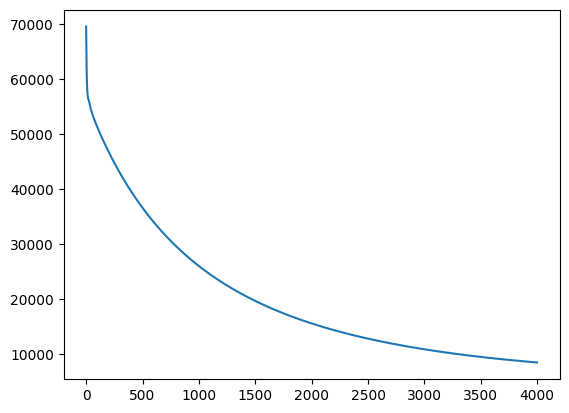

In [50]:
plt.plot(np.array(losses))

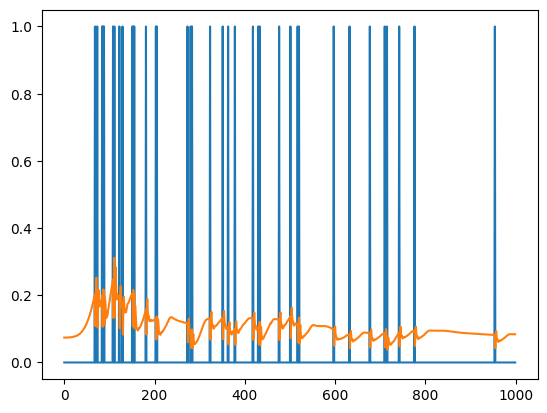

In [51]:

plt.plot(y[:1000])
plt.plot(predictions[:1000])

In [33]:
list(glm_model.parameters())[1]

Parameter containing:
tensor([-1.5572], requires_grad=True)

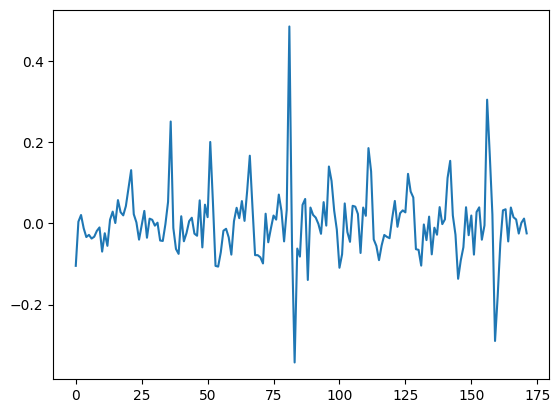

In [52]:
plt.plot(list(glm_model.parameters())[0][0,:].detach().numpy())

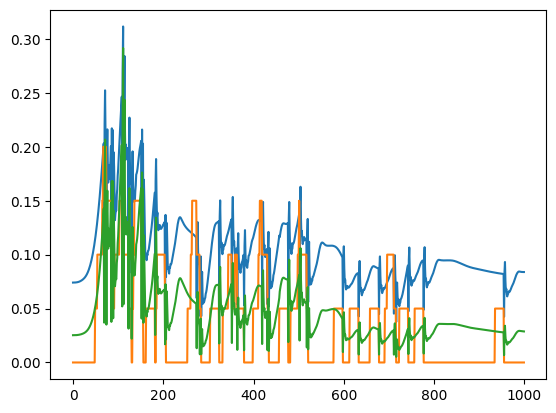

In [53]:
plt.plot(predictions[:1000])
plt.plot(firing_rate.moving_average(data=sp_train[:1000], win=20, step = 1))#firing_rate.moving_average(data=sp_train[:1000], win=20, step = 1))
plt.plot(np.exp(-1.6271782+glm_const + dm_train@ wparams[1:])[:1000])

In [ ]:
list(glm_model.parameters())[1][0].detach().numpy()

array(-1.6271782, dtype=float32)

In [36]:
# 0:const, 1:dm_fix, 2:dm_so1, 3:dm_so5,4:dm_sc1,5:dm_sc5,6:dm_sn0,7:dm_hist,8:sample_on_off,9:dm_do1,10:dm_do5,11:dm_dc1,12:dm_dc5,13:dm_dn0,14:delay_on_off
wparams=list(glm_model.parameters())[0][0,:].detach().numpy()#glm_result.params
variables = list(indices.keys())
glm_vars = {}
glm_const = wparams[0:1]#
glm_vars["glm_const"]=glm_const
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    glm_vars[var] = wparams[st+1:ed+1]# glm_result.params

In [37]:
rate_pred_train = predictions#np.exp(glm_const + dm_train@ wparams[1:])#glm_result.params

KeyError: 'test_orient1'

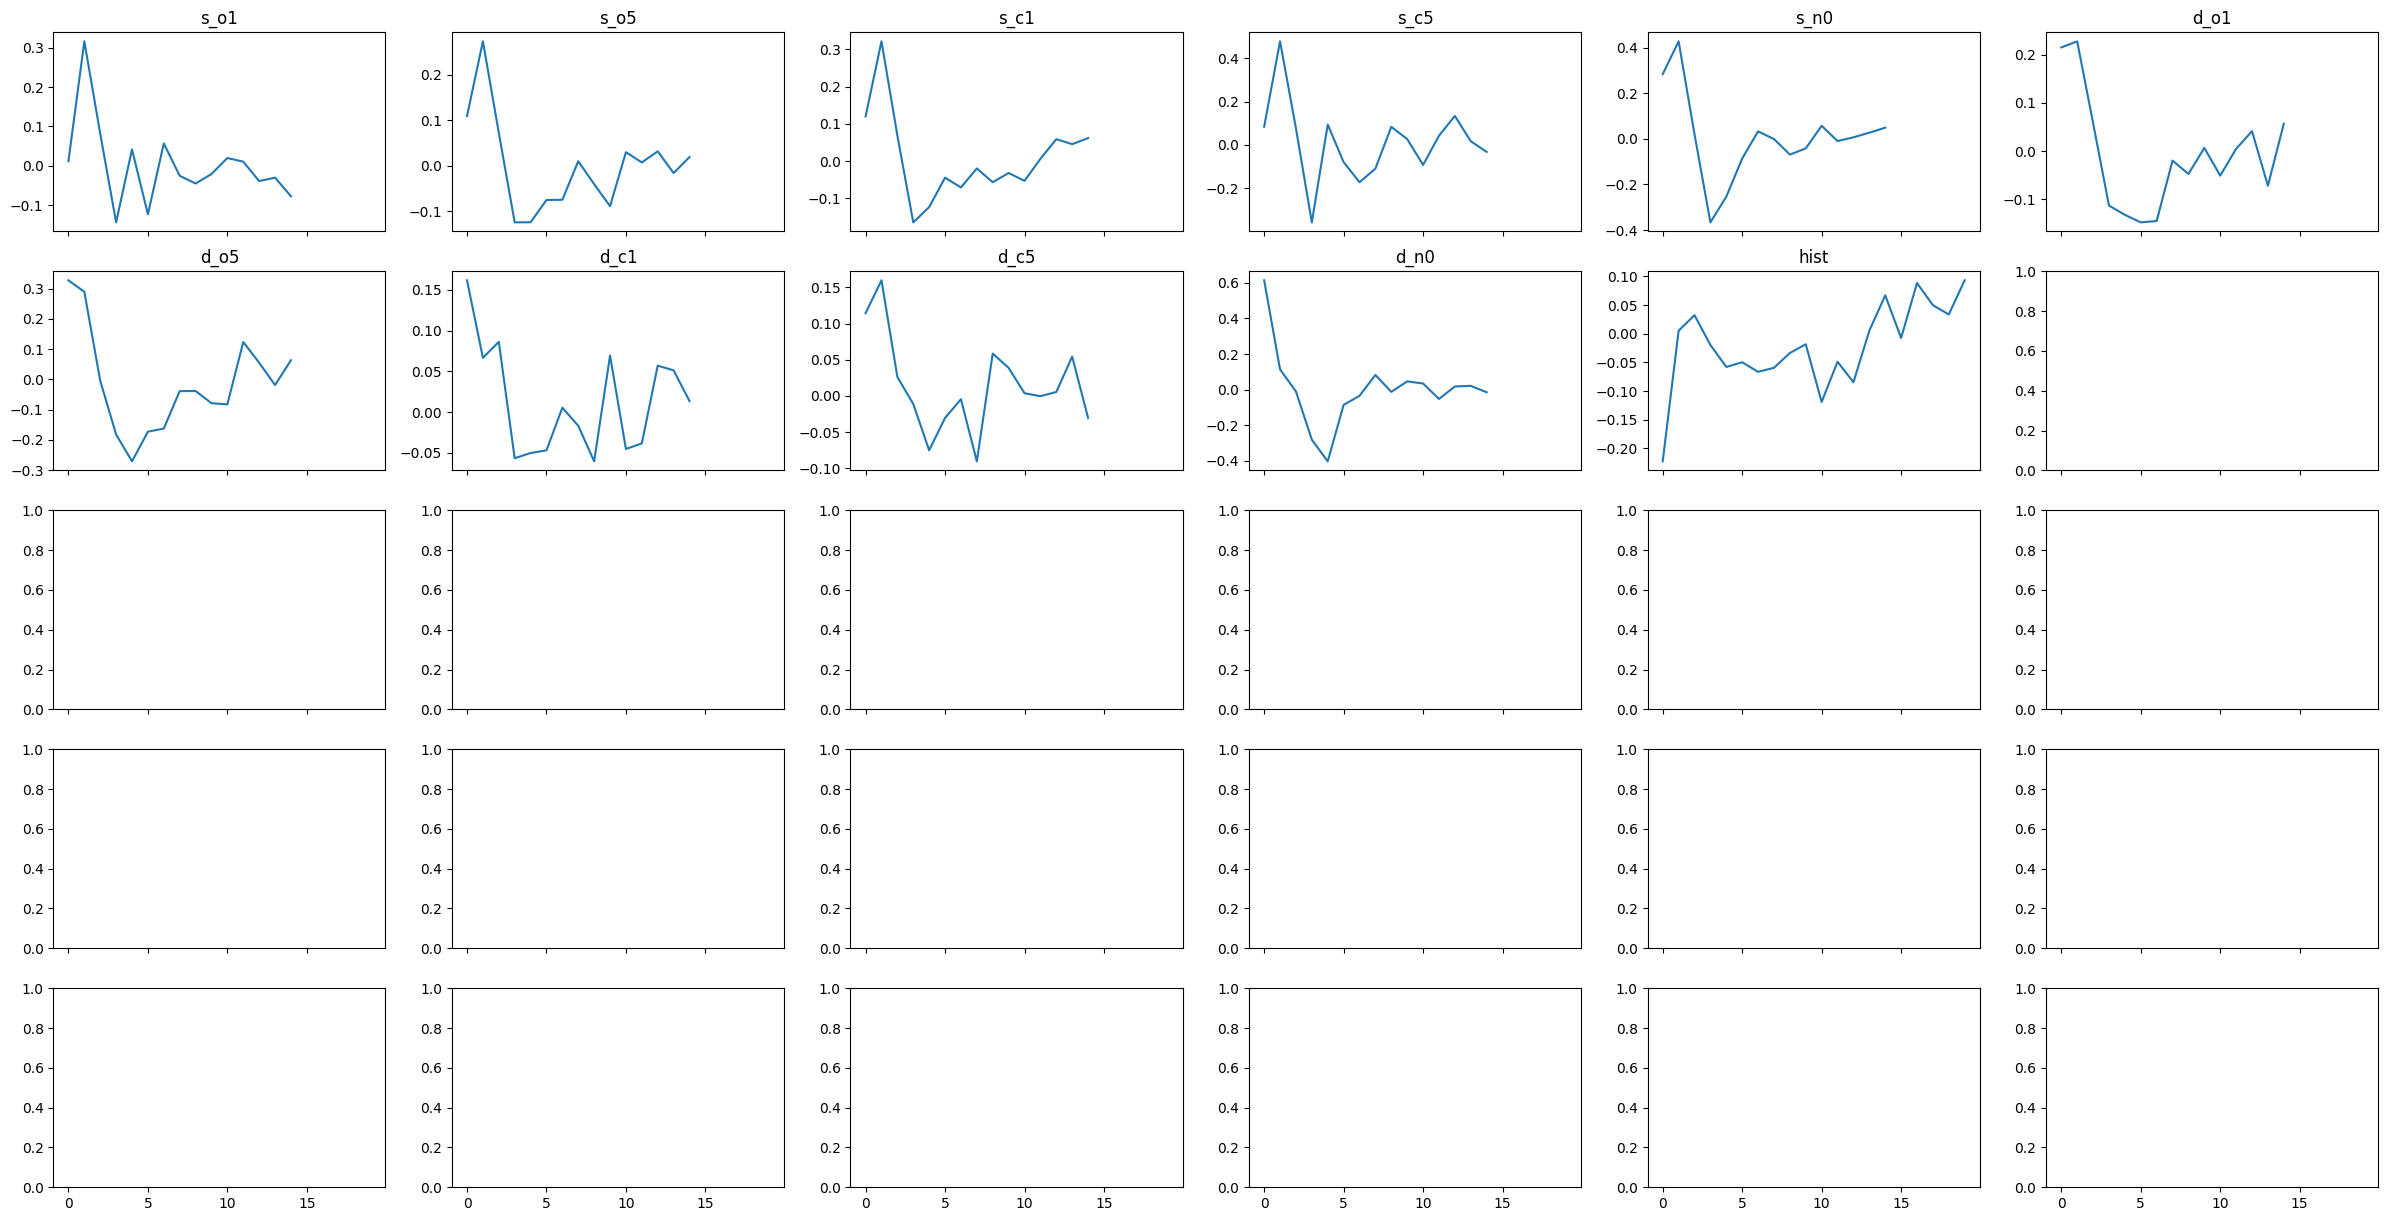

In [39]:
# print filters
variables = [ 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0','hist','test_orient1', 'test_color1', 
             'test_orient2', 'test_color2', 'test_orient3', 'test_color3', 'test_orient4', 'test_color4', 'test_orient5', 'test_color5', 
             'test_orient6', 'test_color6', 'test_orient7', 'test_color7', 'test_orient8', 'test_color8']
cols = 6
rows = len(variables)//cols
rows =rows +1 if len(variables)%cols>0 else rows
f,ax=plt.subplots(rows,cols,figsize=(30,15),sharex=True)
for iax,var in zip(np.concatenate(ax),variables):
    iax.plot(glm_vars[var])
    iax.set_title(var)
f,ax=plt.subplots(figsize=(5,5))
ax.plot(glm_vars['hist'])

In [ ]:
dm_train.shape

(56409, 172)

In [40]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

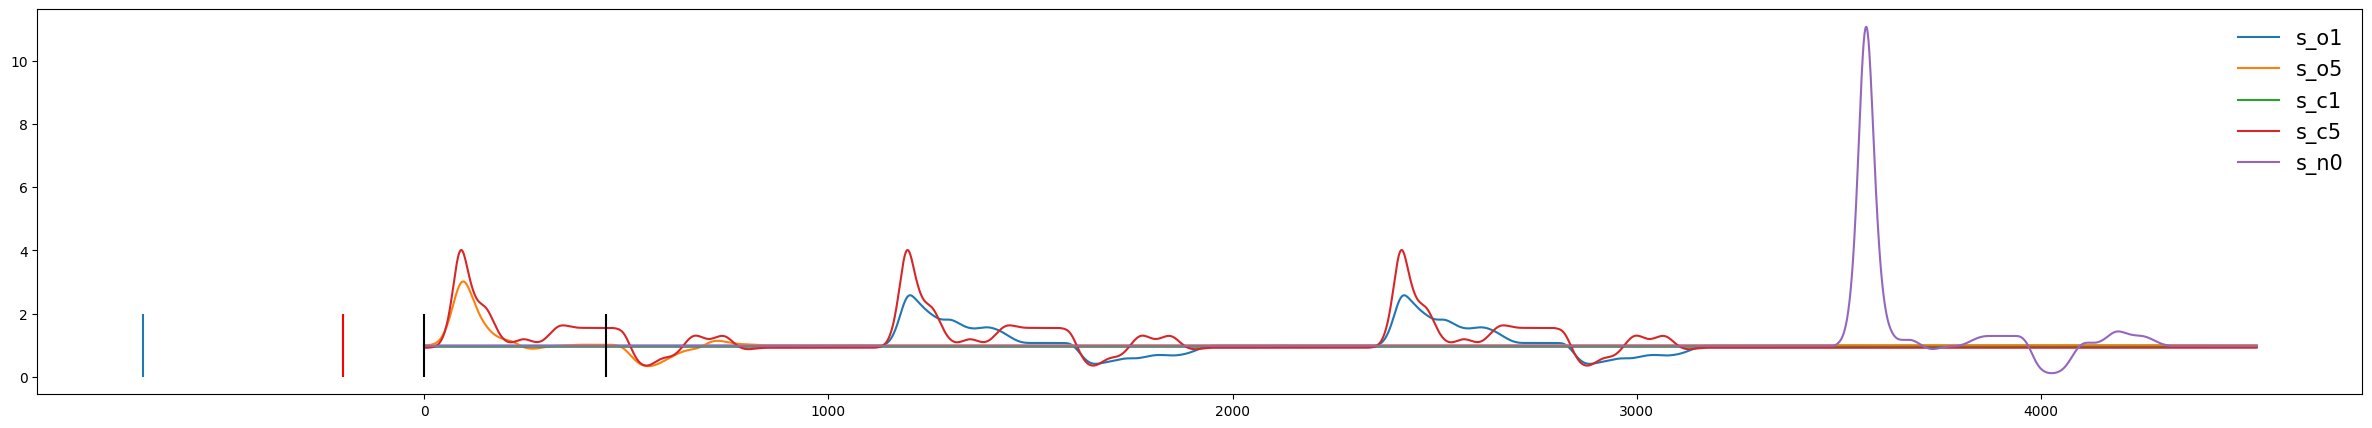

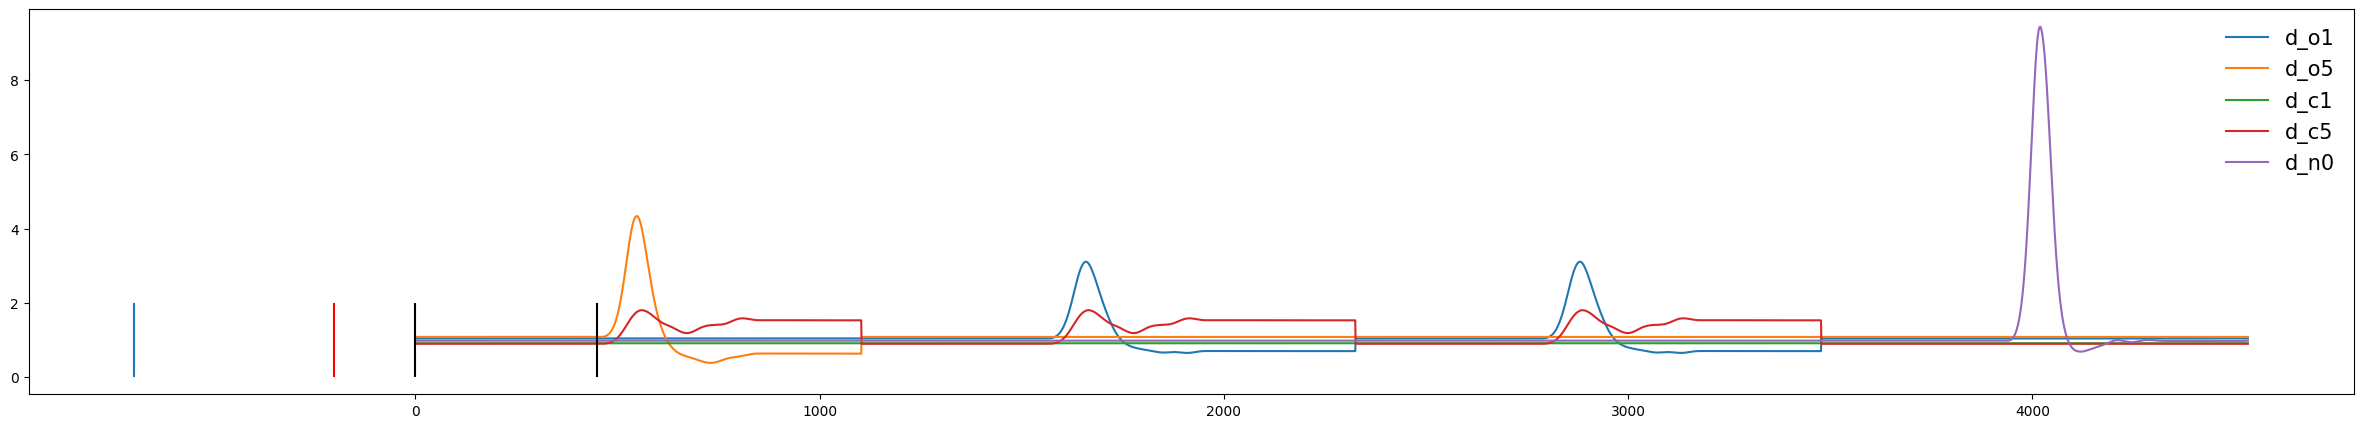

In [41]:
variables = ['s_o1', 's_o5', 's_c1', 's_c5', 's_n0']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[3]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = [ 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[3]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')



KeyError: 'test_color1'

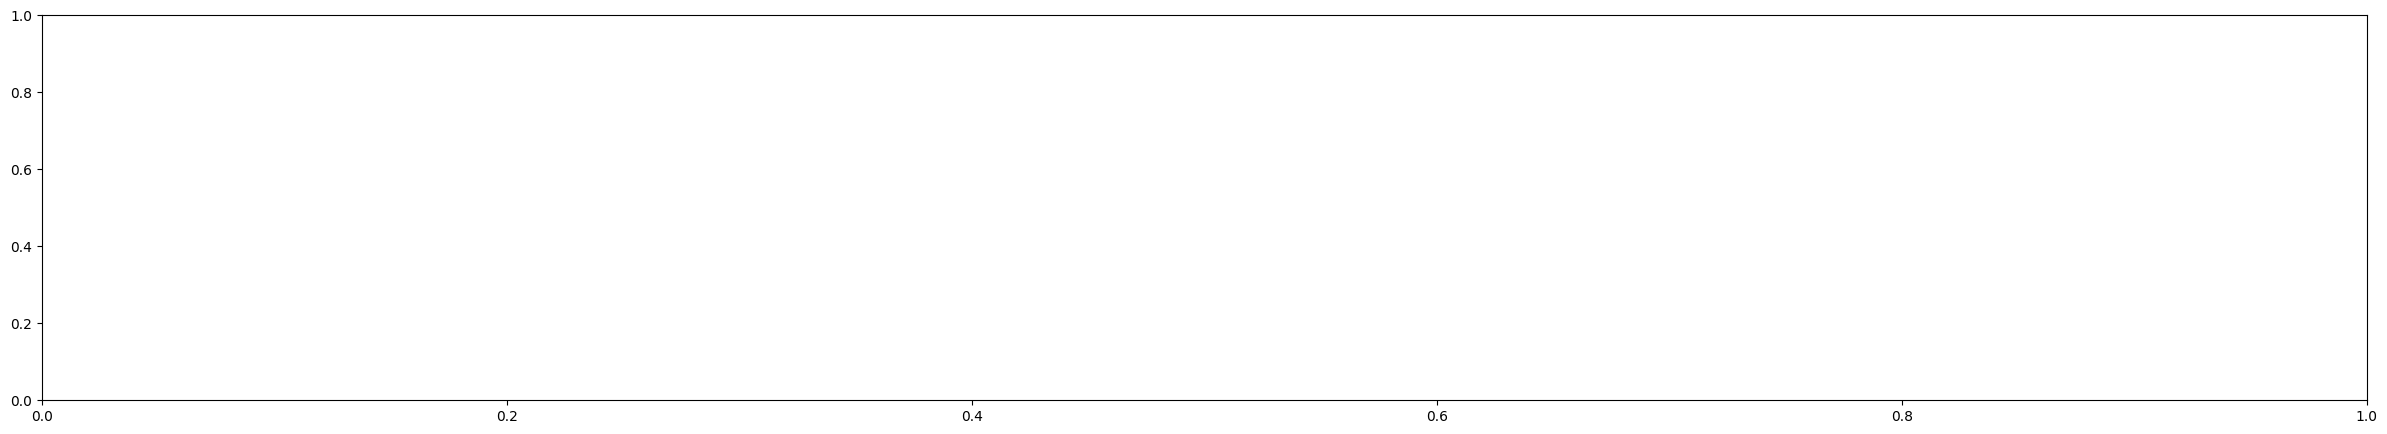

In [ ]:
variables = [ 'test_color1', 
              'test_color2',  'test_color3',  'test_color4',  'test_color5', 
              'test_color6',  'test_color7',  'test_color8']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[-1]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = ['test_orient1', 
             'test_orient2', 'test_orient3', 'test_orient4']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
   
    plt.plot(component[int(start[0]):end[0]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

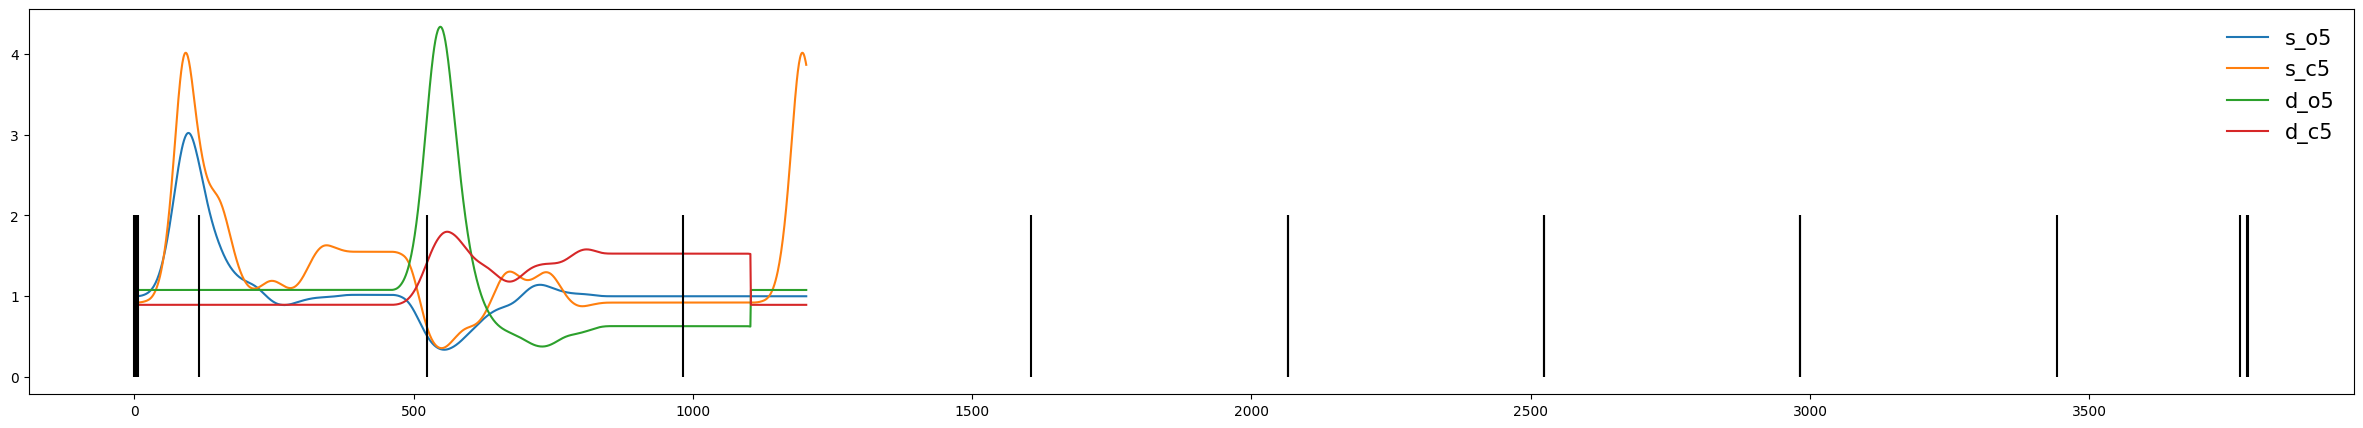

In [42]:
variables = [ 's_o5', 's_c5','d_o5', 'd_c5']#,'test_orient1', 'test_orient8', 'test_orient5', 'test_color5', 'test_color1','match','bar_release']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
   
    plt.plot(component[int(start[0]):end[0]+100],label = var)

plt.vlines(neu_data.code_samples[mask][3]-1000,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [43]:
def get_component(var,dm,glm_vars,indices,start,end):
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm[:,st:ed] @ glm_vars[var])
    return component[start:end]

In [ ]:
var='s_c5'
idx=np.where(neu_data.sample_id[mask][idxs_train]==55)[0]
st= int(start[idx[0]]+s_on_train[idx[0]])
ed=end[idx[0]]
get_component(var,dm_train,glm_vars,indices,start=st,end=ed)

array([0.87296148, 0.87305662, 0.87327028, ..., 0.87293767, 0.87293767,
       0.87293767])

In [ ]:
st

0

In [44]:
all_components={}
# fixation
# var='fix_cue'
# # st = indices[var][0]
# # ed = indices[var][1]
# # component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
# # all_components[var] = component[start[0]:end[0]]
# st = start[0]
# ed = end[0]
# all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# # sample
t_befs= 0#400
vars = ['s_o1','s_o5','s_c1','s_c5','s_n0']
sampl_ids = [11,55,11,55,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_train]==s_id)[0]
    st= int(start[idx[0]]+s_on_train[idx[0]]-t_befs)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# delay
vars = ['d_o1','d_o5','d_c1','d_c5','d_n0']
t_befd = 400
sampl_ids = [11,55,11,55,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_train]==s_id)[0]
    st= int(start[idx[0]]+d_on_train[idx[0]]-t_befd)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)


KeyError: 'fix_cue'

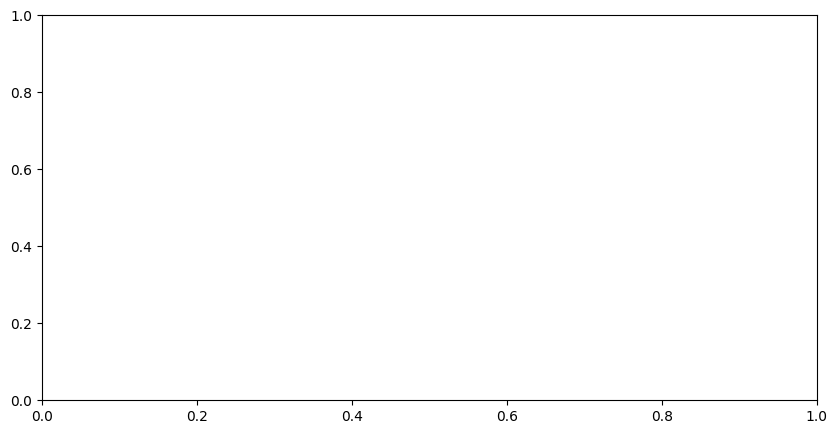

In [ ]:
var='fix_cue'
plt.subplots(figsize=(10,5))
t=np.arange(len(all_components[var]))-s_on_train[0]
plt.plot(t,all_components[var],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")

In [ ]:
all_components['s_c5']

array([0.9889832 , 0.98902107, 0.98910611, ..., 0.98897372, 0.98897372,
       0.98897372])

Text(0.5, 0.98, 'Component')

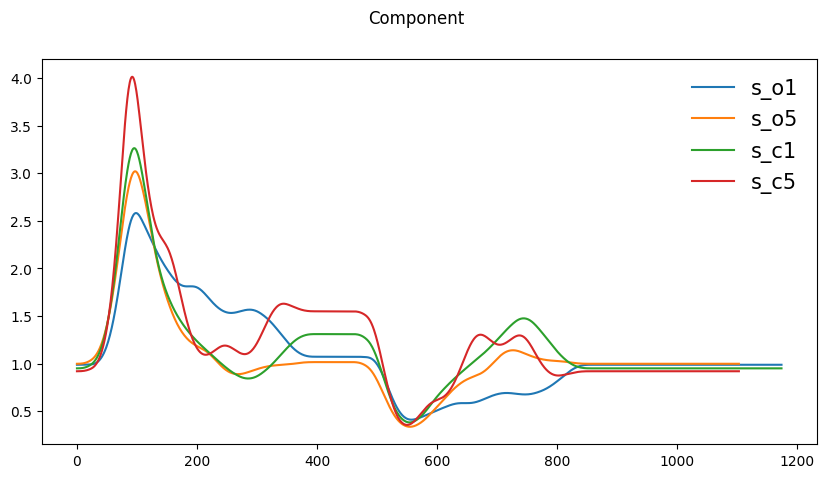

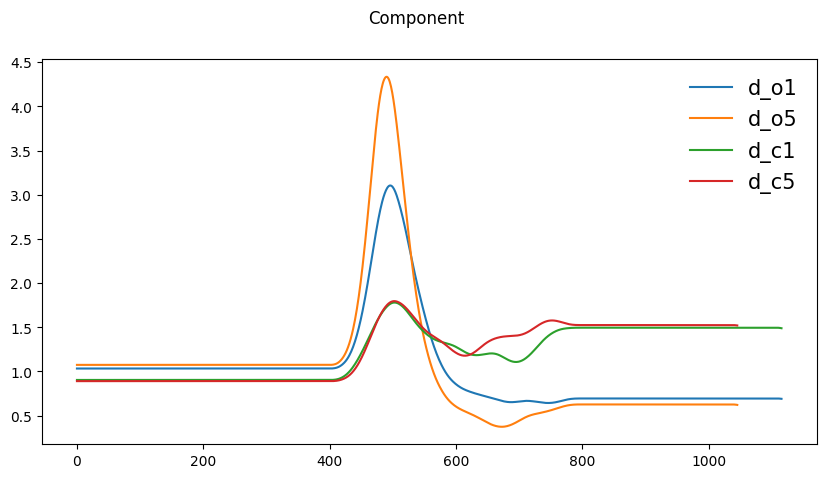

In [45]:
plt.subplots(figsize=(10,5))
for var in ['s_o1','s_o5','s_c1','s_c5']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
    
    plt.plot(t,comp[:],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")
plt.subplots(figsize=(10,5))
for var in ['d_o1','d_o5','d_c1','d_c5']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
   
    plt.plot(t,comp[:],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")

In [ ]:
s_on_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

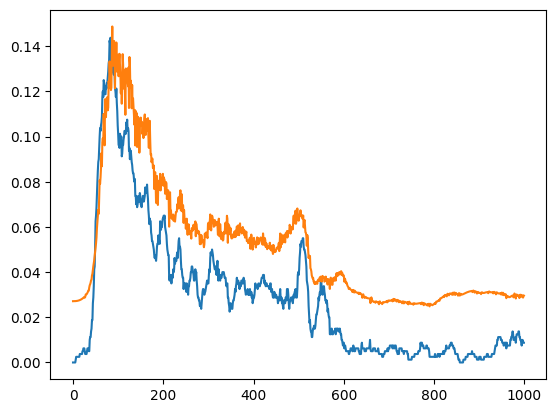

In [46]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    predicted_tr.append(rate_pred_train[start[i_tr]:end[i_tr]][st:int(st+1000)])
no_neu = np.where(neu_data.sample_id[mask][idxs_train][:s_on_train.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    dat = sp_train[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

In [ ]:
rate_pred_test = np.exp(glm_const + dm_test@ wparams[1:])

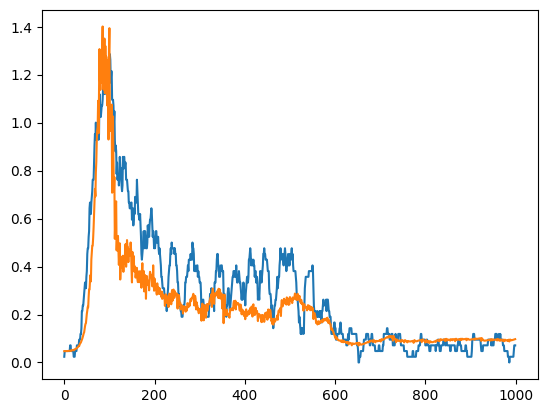

In [ ]:
cumsum = np.cumsum(len_tr_test)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr])
    predicted_tr.append(rate_pred_test[start[i_tr]:end[i_tr]][st:int(st+1000)])
no_neu = np.where(neu_data.sample_id[mask][:s_on_test.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr])
    dat = sp_test[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0)/0.10)
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

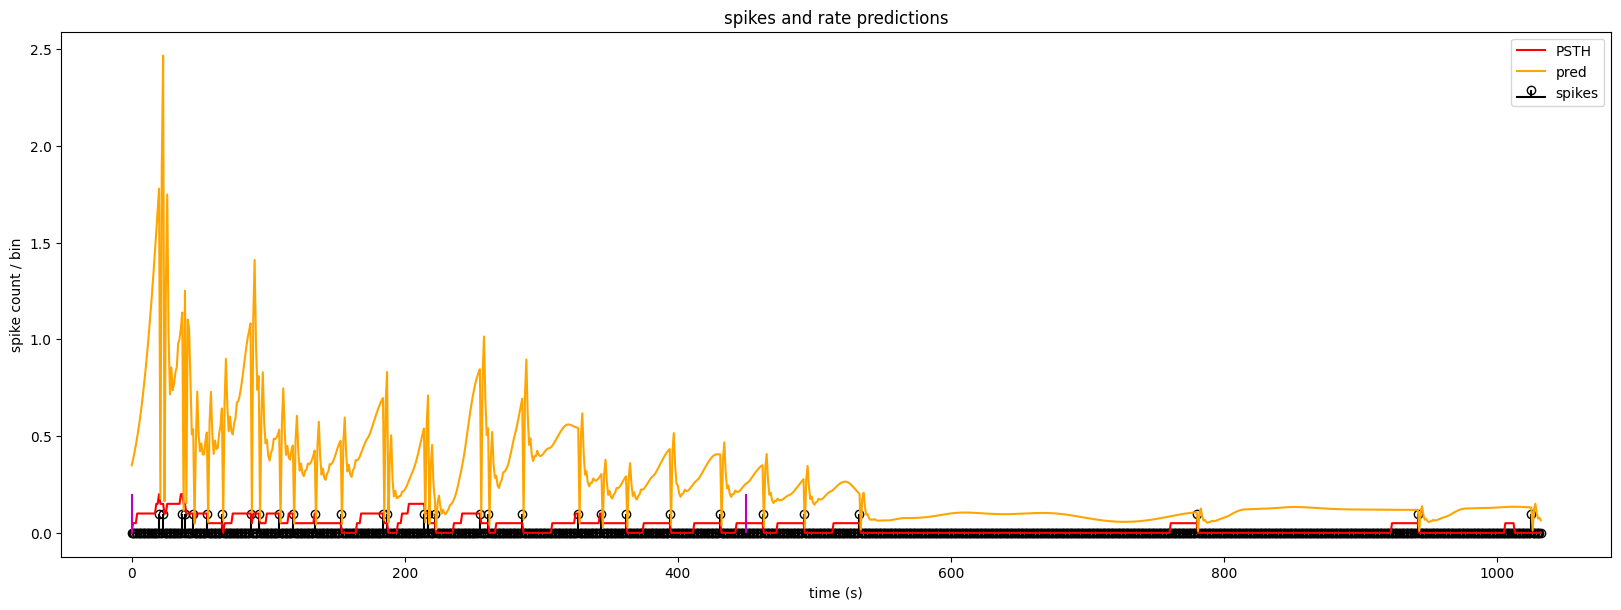

In [ ]:
# Compute predicted spike rate on training data
#rate_pred = np.exp(glm_const + dm_train@ glm_result.params[1:])
it=1
t_start,t_end=start[it],end[it]
# Make plot
fig = plt.figure(figsize=[20,15])
iiplot = np.arange(0,t_end-t_start)
ttplot = iiplot*1
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, (sp_train[t_start:t_end][iiplot]/10), linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
dat= sp_train[t_start:t_end]
plt.plot(ttplot,firing_rate.moving_average(data=dat, win=20, step = 1), c='red', label='PSTH')
plt.plot(ttplot,rate_pred_train[t_start:t_end], c='orange', label='pred')

_=plt.vlines(s_on_train[it],0,0.2,'m')
_=plt.vlines(s_on_train[it]+450,0,0.2,'m')
#_=plt.vlines(fix_on_train[it],0,0.2)

plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()

In [ ]:
design_mat.shape

AttributeError: 'list' object has no attribute 'shape'

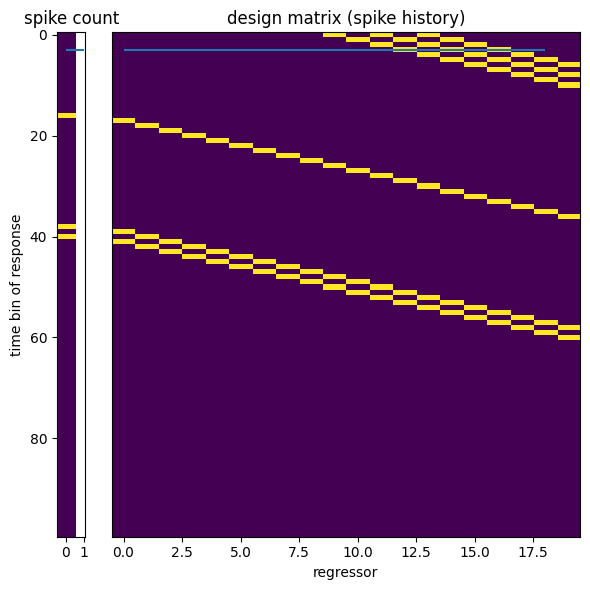

In [ ]:
ntfilt = 20     # Try varying this, to see how performance changes!

# Build the design matrix
padded_stim = np.hstack((np.zeros((ntfilt)), sp_train)) # pad early bins of stimulus with zero
design_mat_hist = np.zeros((len(sp_train),ntfilt))
for j in np.arange(len(sp_train)):
    design_mat_hist[j] = np.flip(padded_stim[j:j+ntfilt]) # grab last 'nkt' bins of stmiulus and insert into this row

t_train,_=dm_train.shape

#dm_train_offset = np.hstack((np.ones((t_train,1)), dm_train))  
fig = plt.figure(figsize=[6,6])
plt.subplot(1,10,(2,10))
plt.imshow(design_mat_hist[165:265], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.hlines(3,0,18)
plt.xlabel('regressor')

plt.title('design matrix (spike history)')
plt.subplot(1,10,1)
plt.imshow(sp_train[165:265,np.newaxis], aspect='auto', interpolation='nearest')
plt.ylabel('time bin of response')
plt.title('spike count')
plt.tight_layout()
plt.hlines(3,0,1)
plt.show()

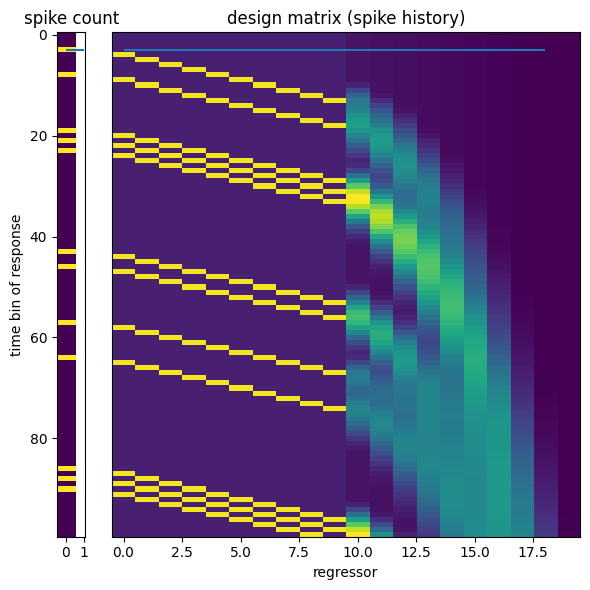

In [ ]:
fig = plt.figure(figsize=[6,6])
plt.subplot(1,10,(2,10))
plt.imshow(dm_train[165:265,0:20], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.hlines(3,0,18)
plt.xlabel('regressor')

plt.title('design matrix (spike history)')
plt.subplot(1,10,1)
plt.imshow(sp_train[165:265,np.newaxis], aspect='auto', interpolation='nearest')
plt.ylabel('time bin of response')
plt.title('spike count')
plt.tight_layout()
plt.hlines(3,0,1)
plt.show()